# **Restricted Boltzmann Machine(RBM)**

## Load the MINIST dataset :

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

BATCHSIZE = 16
VISIBLE_UNITS = 28*28
HIDDEN_UNITS = 100
CD_K = 2
EPOCHS = 20

# load datasets
tr_dataset = datasets.MNIST('data/mnist', train=True, transform=transforms.ToTensor(), download=True)
tr_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=BATCHSIZE)
ts_dataset = datasets.MNIST('data/mnist', train=False, transform=transforms.ToTensor(), download=True)
ts_loader = torch.utils.data.DataLoader(ts_dataset, batch_size=BATCHSIZE)
train_set, val_set = torch.utils.data.random_split(tr_dataset, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCHSIZE)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCHSIZE)


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw




Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw




Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


## Define RBM model

In [2]:
class RBM():
  def __init__(self, n_visible=VISIBLE_UNITS, n_hidden=HIDDEN_UNITS, k=CD_K, lr=1e-1, momentum_rate=0.5, w_decay=1e-4):
    self.n_visible = n_visible
    self.n_hidden = n_hidden
    self.k = k
    self.lr = lr
    self.momentum_rate = momentum_rate
    self.w_decay = w_decay
  
    self.w = torch.randn(n_visible, n_hidden) * 0.1
    self.visible_b = torch.ones(n_visible) * 0.5
    self.hidden_b = torch.zeros(n_hidden)

    self.w_momentum = torch.zeros(n_visible, n_hidden)
    self.visible_b_momentum = torch.zeros(n_visible)
    self.hidden_b_momentum = torch.zeros(n_hidden)

  def _sample(self, p, size):
    return (p >= torch.rand(size)).float()

  def v2h(self, visible_p):
    hidden_activations = torch.matmul(visible_p, self.w) + self.hidden_b
    hidden_p = 1 / (1 + torch.exp(-hidden_activations))
    return hidden_p, self._sample(hidden_p, self.n_hidden)

  def h2v(self, hidden):
    visible_activations = torch.matmul(hidden, self.w.t()) + self.visible_b
    visible_p = 1 / (1 + torch.exp(-visible_activations))
    return visible_p, self._sample(visible_p, self.n_visible)

  def cd(self, input):
    # wake part
    pos_hidden_p, pos_hidden = self.v2h(input)
    wake = torch.matmul(input.t(), pos_hidden_p)

    # dream part
    neg_hidden = pos_hidden
    for step in range(self.k):
      recon_visible_p, _ = self.h2v(neg_hidden)
      neg_hidden_p, neg_hidden = self.v2h(recon_visible_p)
    
    dream = torch.matmul(recon_visible_p.t(), neg_hidden_p)
    Delta_w = wake - dream

    #update parameters
    self.w_momentum = self.momentum_rate*(self.w_momentum) + Delta_w
    self.visible_b_momentum = self.momentum_rate*(self.visible_b_momentum) + torch.sum(input - recon_visible_p, dim=0)
    self.hidden_b_momentum = self.momentum_rate*(self.hidden_b_momentum) + torch.sum(pos_hidden_p - neg_hidden_p, dim=0)


    batch_size = input.size(0)
    self.w += self.w_momentum * self.lr / batch_size
    self.visible_b += self.visible_b_momentum * self.lr / batch_size
    self.hidden_b += self.hidden_b_momentum * self.lr / batch_size

    self.w -= self.w * self.w_decay
    #reconstruciton error
    err = torch.sum((input - recon_visible_p)**2)

    return err, input, recon_visible_p, self._sample(recon_visible_p, self.n_visible)

  def train(self, n_epochs, tr_loader, verbose=1):
    # training RBM
    for epoch in range(n_epochs):
      epoch_err = 0.0

      for batch, _ in tr_loader:
        batch = batch.view(len(batch), self.n_visible)
        batch_err, data, recon_data_p, recon_data = self.cd(batch)
        epoch_err += batch_err
      if verbose:
        print("Epoch Error (epoch=%d): %.4f" % (epoch+1, epoch_err))


## Train RBM model

In [3]:
rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K)
rbm.train(EPOCHS, tr_loader)

Epoch Error (epoch=1): 1266606.2500
Epoch Error (epoch=2): 961255.0000
Epoch Error (epoch=3): 904477.6250
Epoch Error (epoch=4): 879825.0000
Epoch Error (epoch=5): 866156.5625
Epoch Error (epoch=6): 856422.0625
Epoch Error (epoch=7): 847469.8750
Epoch Error (epoch=8): 842936.6875
Epoch Error (epoch=9): 839906.6250
Epoch Error (epoch=10): 834929.3125
Epoch Error (epoch=11): 834472.8125
Epoch Error (epoch=12): 831009.9375
Epoch Error (epoch=13): 829198.0625
Epoch Error (epoch=14): 827183.1875
Epoch Error (epoch=15): 827483.4375
Epoch Error (epoch=16): 823220.5000
Epoch Error (epoch=17): 820216.8125
Epoch Error (epoch=18): 819425.8125
Epoch Error (epoch=19): 817430.2500
Epoch Error (epoch=20): 814744.3125


## Define a classification model by placing a softmax layer after the RBM

In [4]:
class RBM_Net(torch.nn.Module):
    def __init__(self, rbm, input_dim, output_dim):
        super(RBM_Net, self).__init__()
        self.rbm = rbm
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x, _ = self.rbm.v2h(x)
        x = self.linear(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=10):
        history_tr = []
        history_ts = []
        for epoch in range(epochs):
          correct_tr = 0
          total_tr = 0
          y_true_tr = []
          y_pred_tr = []
          loss = 0
          for i, (batch_tr, labels_tr) in enumerate(tr_loader):
            batch_tr = Variable(batch_tr.view(-1, VISIBLE_UNITS))
            labels_tr = Variable(labels_tr)

            optimizer.zero_grad()
            outputs_tr = clf(batch_tr)
            loss_tr = criterion(outputs_tr, labels_tr)
            _, prediction_tr = torch.max(outputs_tr.data, 1)
            y_true_tr.extend(labels_tr)
            y_pred_tr.extend(prediction_tr)
            total_tr += labels_tr.size(0)
            correct_tr += (prediction_tr == labels_tr).sum()
            loss_tr.backward()
            optimizer.step()
            loss += loss_tr / batch_tr.size(0)
          accuracy_tr = correct_tr / total_tr * 100
          history_tr.append(accuracy_tr.data)
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          history_ts.append(accuracy.data)
          print("Epoch : {0:2d} | loss : {1:.4f} | Train Accuracy: {2:.2f}  | Test Accuracy: {3:.2f}".format(epoch+1, loss.item(), accuracy_tr, accuracy))
      
        return y_true_tr, y_pred_tr, y_true, y_pred, history_tr, history_ts

rbm_Model = RBM_Net(rbm, HIDDEN_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(rbm_Model.parameters(), lr=1e-3)
print(rbm_Model)

RBM_Net(
  (linear): Linear(in_features=100, out_features=10, bias=True)
)


### Train the classifier :

In [5]:
_,_,_,_,history_train,history_val = rbm_Model.train(train_loader, val_loader, optimizer, rbm_Model, criterion)

Epoch :  1 | loss : 111.3831 | Train Accuracy: 85.75  | Test Accuracy: 90.59
Epoch :  2 | loss : 61.5660 | Train Accuracy: 90.87  | Test Accuracy: 91.58
Epoch :  3 | loss : 55.5394 | Train Accuracy: 91.63  | Test Accuracy: 92.09
Epoch :  4 | loss : 52.7590 | Train Accuracy: 91.95  | Test Accuracy: 92.29
Epoch :  5 | loss : 51.1256 | Train Accuracy: 92.21  | Test Accuracy: 92.43
Epoch :  6 | loss : 50.0475 | Train Accuracy: 92.36  | Test Accuracy: 92.53
Epoch :  7 | loss : 49.2844 | Train Accuracy: 92.46  | Test Accuracy: 92.64
Epoch :  8 | loss : 48.7185 | Train Accuracy: 92.52  | Test Accuracy: 92.70
Epoch :  9 | loss : 48.2840 | Train Accuracy: 92.55  | Test Accuracy: 92.70
Epoch : 10 | loss : 47.9418 | Train Accuracy: 92.60  | Test Accuracy: 92.77


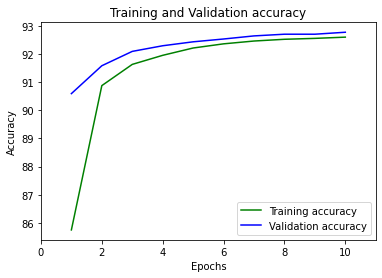

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_train)+1)
plt.plot(epochs, history_train, 'g', label='Training accuracy')
plt.plot(epochs, history_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0, len(history_train)+1])
plt.xticks(np.linspace(0, len(history_train), 6))
plt.legend(loc='lower right')
plt.show()

In [7]:
rbm_Model = RBM_Net(rbm, HIDDEN_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(rbm_Model.parameters(), lr=1e-3)
print(rbm_Model)
y_true_tr,y_pred_tr,y_true,y_pred,history_tr,history_ts = rbm_Model.train(tr_loader, ts_loader, optimizer, rbm_Model, criterion)

RBM_Net(
  (linear): Linear(in_features=100, out_features=10, bias=True)
)
Epoch :  1 | loss : 125.1213 | Train Accuracy: 86.49  | Test Accuracy: 90.89
Epoch :  2 | loss : 71.3092 | Train Accuracy: 91.08  | Test Accuracy: 92.02
Epoch :  3 | loss : 64.9578 | Train Accuracy: 91.86  | Test Accuracy: 92.26
Epoch :  4 | loss : 62.0575 | Train Accuracy: 92.15  | Test Accuracy: 92.43
Epoch :  5 | loss : 60.3805 | Train Accuracy: 92.33  | Test Accuracy: 92.49
Epoch :  6 | loss : 59.2911 | Train Accuracy: 92.46  | Test Accuracy: 92.67
Epoch :  7 | loss : 58.5317 | Train Accuracy: 92.52  | Test Accuracy: 92.67
Epoch :  8 | loss : 57.9762 | Train Accuracy: 92.59  | Test Accuracy: 92.78
Epoch :  9 | loss : 57.5555 | Train Accuracy: 92.64  | Test Accuracy: 92.78
Epoch : 10 | loss : 57.2282 | Train Accuracy: 92.65  | Test Accuracy: 92.80


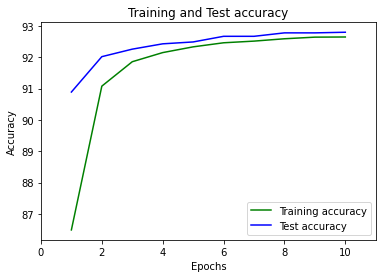

In [8]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_tr)+1)
plt.plot(epochs, history_tr, 'g', label='Training accuracy')
plt.plot(epochs, history_ts, 'b', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0, len(history_tr)+1])
plt.xticks(np.linspace(0, len(history_tr), 6))
plt.legend(loc='lower right')
plt.show()

### Build the confusion matrix :

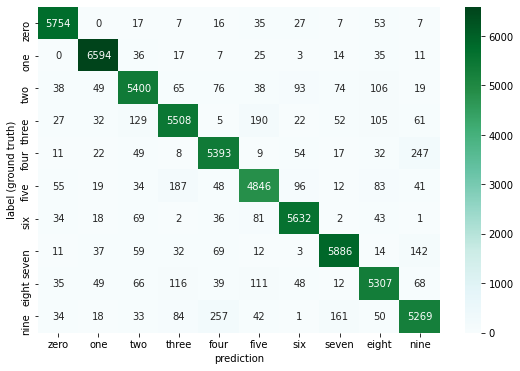

In [9]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Train
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

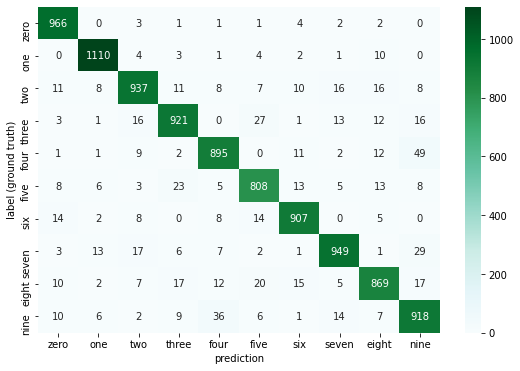

In [10]:
# Test
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

## Define a classification model taking the RBM hidden states as embbedings.

In [11]:
class EMB_RBM_Net(torch.nn.Module):
    def __init__(self, rbm, input_dim, output_dim):
        super(EMB_RBM_Net, self).__init__()
        self.rbm = rbm
        self.fl1 = torch.nn.Linear(input_dim, HIDDEN_UNITS)
        self.fl1.weight.data.copy_(torch.transpose(self.rbm.w, 0, 1))
        self.fl1.bias.data.copy_(self.rbm.hidden_b)
        self.fl2 = torch.nn.Linear(HIDDEN_UNITS, output_dim)

    def forward(self, x):
        x = self.fl1(x)
        x = F.sigmoid(x)
        x = self.fl2(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=10):
        history_tr = []
        history_ts = []
        for epoch in range(epochs):
          correct_tr = 0
          total_tr = 0
          y_true_tr = []
          y_pred_tr = []
          loss = 0
          for i, (batch_tr, labels_tr) in enumerate(tr_loader):
            batch_tr = Variable(batch_tr.view(-1, VISIBLE_UNITS))
            labels_tr = Variable(labels_tr)

            optimizer.zero_grad()
            outputs_tr = clf(batch_tr)
            loss_tr = criterion(outputs_tr, labels_tr)
            _, prediction_tr = torch.max(outputs_tr.data, 1)
            y_true_tr.extend(labels_tr)
            y_pred_tr.extend(prediction_tr)
            total_tr += labels_tr.size(0)
            correct_tr += (prediction_tr == labels_tr).sum()
            loss_tr.backward()
            optimizer.step()
            loss += loss_tr / batch_tr.size(0)
          accuracy_tr = correct_tr / total_tr * 100
          history_tr.append(accuracy_tr.data)
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          history_ts.append(accuracy.data)
          print("Epoch : {0:2d} | loss : {1:.4f} | Train Accuracy: {2:.2f}  | Test Accuracy: {3:.2f}".format(epoch+1, loss.item(), accuracy_tr, accuracy))
      
        return y_true_tr, y_pred_tr, y_true, y_pred, history_tr, history_ts

emb_rbm_Model = EMB_RBM_Net(rbm, VISIBLE_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(emb_rbm_Model.parameters(), lr=1e-3)
print(emb_rbm_Model)

EMB_RBM_Net(
  (fl1): Linear(in_features=784, out_features=100, bias=True)
  (fl2): Linear(in_features=100, out_features=10, bias=True)
)


### Train the classifier :

In [12]:
_,_,_,_,history_train,history_val = emb_rbm_Model.train(train_loader, val_loader, optimizer, emb_rbm_Model, criterion)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :  1 | loss : 91.7425 | Train Accuracy: 88.21  | Test Accuracy: 93.27
Epoch :  2 | loss : 38.3996 | Train Accuracy: 94.38  | Test Accuracy: 95.07
Epoch :  3 | loss : 28.6103 | Train Accuracy: 95.79  | Test Accuracy: 95.76
Epoch :  4 | loss : 22.8079 | Train Accuracy: 96.70  | Test Accuracy: 96.14
Epoch :  5 | loss : 18.7632 | Train Accuracy: 97.39  | Test Accuracy: 96.45
Epoch :  6 | loss : 15.6392 | Train Accuracy: 97.86  | Test Accuracy: 96.60
Epoch :  7 | loss : 13.1476 | Train Accuracy: 98.24  | Test Accuracy: 96.63
Epoch :  8 | loss : 11.1207 | Train Accuracy: 98.56  | Test Accuracy: 96.69
Epoch :  9 | loss : 9.4467 | Train Accuracy: 98.80  | Test Accuracy: 96.69
Epoch : 10 | loss : 8.0222 | Train Accuracy: 99.00  | Test Accuracy: 96.86


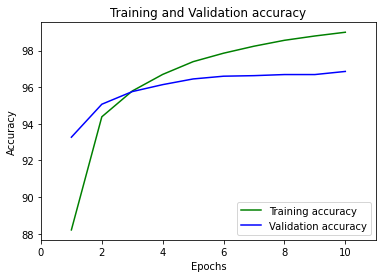

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_train)+1)
plt.plot(epochs, history_train, 'g', label='Training accuracy')
plt.plot(epochs, history_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0, len(history_train)+1])
plt.xticks(np.linspace(0, len(history_train), 6))
plt.legend(loc='lower right')
plt.show()

In [14]:
emb_rbm_Model = EMB_RBM_Net(rbm, VISIBLE_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(emb_rbm_Model.parameters(), lr=1e-3)
print(emb_rbm_Model)
y_true_tr,y_pred_tr,y_true,y_pred,history_tr,history_ts = emb_rbm_Model.train(tr_loader, ts_loader, optimizer, emb_rbm_Model, criterion)

EMB_RBM_Net(
  (fl1): Linear(in_features=784, out_features=100, bias=True)
  (fl2): Linear(in_features=100, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :  1 | loss : 98.3314 | Train Accuracy: 89.64  | Test Accuracy: 94.15
Epoch :  2 | loss : 42.6723 | Train Accuracy: 94.91  | Test Accuracy: 95.52
Epoch :  3 | loss : 31.7672 | Train Accuracy: 96.13  | Test Accuracy: 96.16
Epoch :  4 | loss : 25.3514 | Train Accuracy: 96.93  | Test Accuracy: 96.45
Epoch :  5 | loss : 20.9618 | Train Accuracy: 97.51  | Test Accuracy: 96.69
Epoch :  6 | loss : 17.6069 | Train Accuracy: 97.93  | Test Accuracy: 96.75
Epoch :  7 | loss : 14.8600 | Train Accuracy: 98.28  | Test Accuracy: 96.88
Epoch :  8 | loss : 12.5734 | Train Accuracy: 98.58  | Test Accuracy: 96.92
Epoch :  9 | loss : 10.6516 | Train Accuracy: 98.82  | Test Accuracy: 96.93
Epoch : 10 | loss : 9.0249 | Train Accuracy: 99.07  | Test Accuracy: 96.94


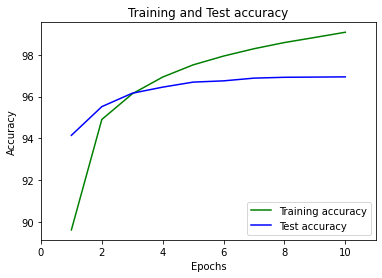

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_tr)+1)
plt.plot(epochs, history_tr, 'g', label='Training accuracy')
plt.plot(epochs, history_ts, 'b', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0, len(history_tr)+1])
plt.xticks(np.linspace(0, len(history_tr), 6))
plt.legend(loc='lower right')
plt.show()

### Check the pretrained RBM layer weights to make sure it is updated :

In [16]:
emb_rbm_Model.fl1.weight.data == torch.transpose(rbm.w, 0, 1)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [17]:
(emb_rbm_Model.fl1.weight.data == torch.transpose(rbm.w, 0, 1)).all()

tensor(False)

### Build the confusion matrix :

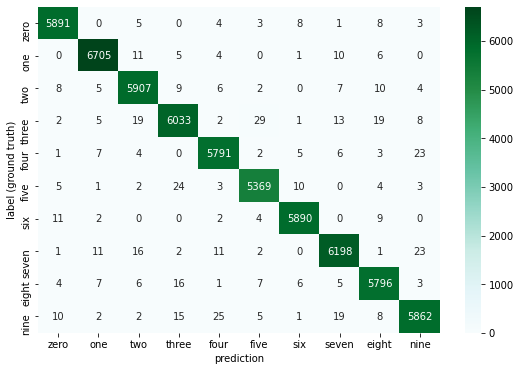

In [18]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Train
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

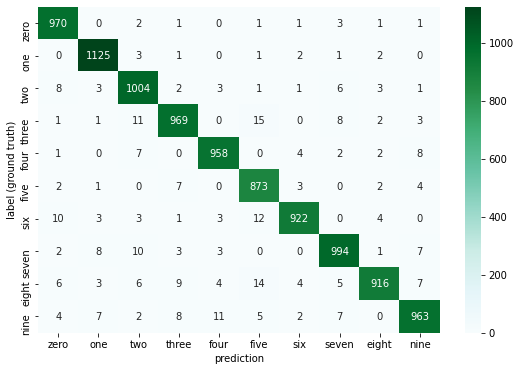

In [19]:
# Test
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

# **Deep Belief network(DBN)** :

## Define DBN model:

In [20]:
class DBN(nn.Module):
  def __init__(self, n_visible=VISIBLE_UNITS, n_hiddens=[HIDDEN_UNITS, HIDDEN_UNITS, HIDDEN_UNITS], k=1):
    super(DBN, self).__init__()
    
    self.n_layers = len(n_hiddens)
    self.rbm_layers = []
  
    # creating different RBM layers
    for i in range(self.n_layers):
      n_input = 0;
      if i == 0:
        n_input = n_visible
      else:
        n_input = n_hiddens[i-1]
      rbm = RBM(n_input, n_hiddens[i], k)
      self.rbm_layers.append(rbm)

  def forward(self, input):
    '''
    running the forward pass
    '''
    visible = input 
    for i in range(len(self.rbm_layers)):
      hidden_p, hidden = self.rbm_layers[i].v2h(visible)
      visible = hidden_p
    return hidden_p, hidden

  def reconstruct(self, input):
    '''
    go till the final layer and then reconstruct
    '''
    hidden_p, h = self.forward(input)
    hidden = h

    for i in range(len(self.rbm_layers)-1,-1,-1):
      recon_visible_p, recon_visible = self.rbm_layers[i].h2v(hidden)
      hidden = recon_visible
    return recon_visible_p, recon_visible

  def train(self,  train_data, train_labels, n_epochs=EPOCHS, batch_size=16, debug=True):
    verbose = 1
    transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
    train_data = torch.stack([transform(data) for data in train_data]).squeeze()
    tmp = train_data
    for i in range(len(self.rbm_layers)):
      if debug:
        print("-"*40)
        print("Training rbm layer number {}".format(i+1))
      
      if i:
        verbose = 0

      # Transform raw input data for rbm_layers 0:
      tensor_data = tmp.type(torch.FloatTensor)
      tensor_label = train_labels.type(torch.FloatTensor)
      dataset = torch.utils.data.TensorDataset(tensor_data, tensor_label)
      data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

      if not debug:
        verbose = 0

      self.rbm_layers[i].train(n_epochs, data_loader, verbose)
      visible = tensor_data.view((tensor_data.shape[0], -1))
      hidden_p, _ = self.rbm_layers[i].v2h(visible)
      tmp = hidden_p
      
      # Reconstruct Error for last layer
      if i == len(self.rbm_layers)-1:
        train_data = train_data.view((train_data.shape[0], -1))
        recon_visible_p, recon_visible = self.reconstruct(train_data)
        err = torch.sum((train_data - recon_visible_p)**2)
        if debug:
          print("Reconstruct Error : %.4f" % err)
    return

## Train DBN

In [21]:
dbn = DBN()
dbn.train(tr_dataset.train_data, tr_dataset.train_labels)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


----------------------------------------
Training rbm layer number 1
Epoch Error (epoch=1): 1011952.3125
Epoch Error (epoch=2): 769859.3125
Epoch Error (epoch=3): 727651.6250
Epoch Error (epoch=4): 705512.6875
Epoch Error (epoch=5): 690776.5625
Epoch Error (epoch=6): 683168.5000
Epoch Error (epoch=7): 677280.6875
Epoch Error (epoch=8): 673025.8125
Epoch Error (epoch=9): 670099.4375
Epoch Error (epoch=10): 666632.2500
Epoch Error (epoch=11): 664931.2500
Epoch Error (epoch=12): 664068.8750
Epoch Error (epoch=13): 661372.4375
Epoch Error (epoch=14): 661527.7500
Epoch Error (epoch=15): 659328.9375
Epoch Error (epoch=16): 658012.9375
Epoch Error (epoch=17): 656367.5000
Epoch Error (epoch=18): 655224.0000
Epoch Error (epoch=19): 655419.8125
Epoch Error (epoch=20): 653606.5000
----------------------------------------
Training rbm layer number 2
----------------------------------------
Training rbm layer number 3
Reconstruct Error : 1437730.5000


## Visualising DBN layer :

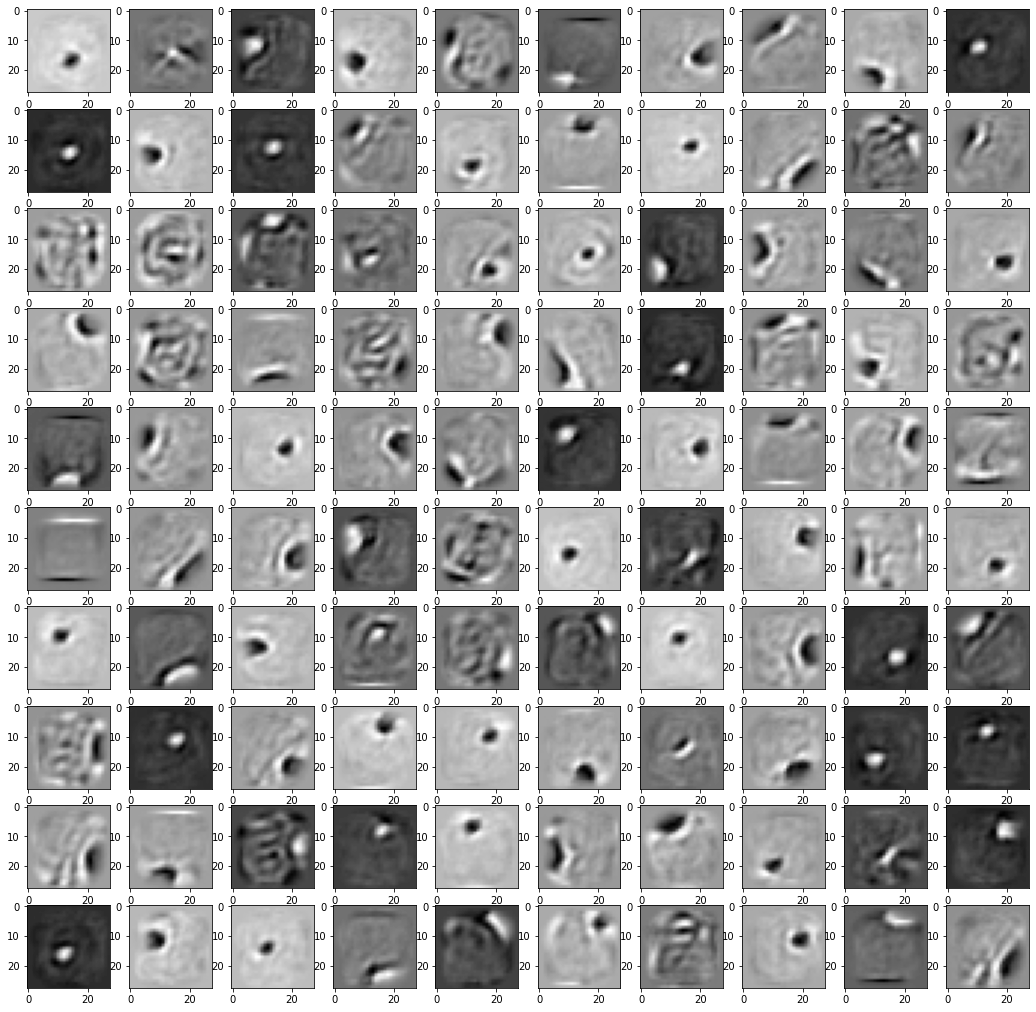

In [22]:
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

# visualising layer 1
learned_weights = dbn.rbm_layers[0].w.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(18,18))
for i in range(100): 
    sub = fig.add_subplot(10, 10, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

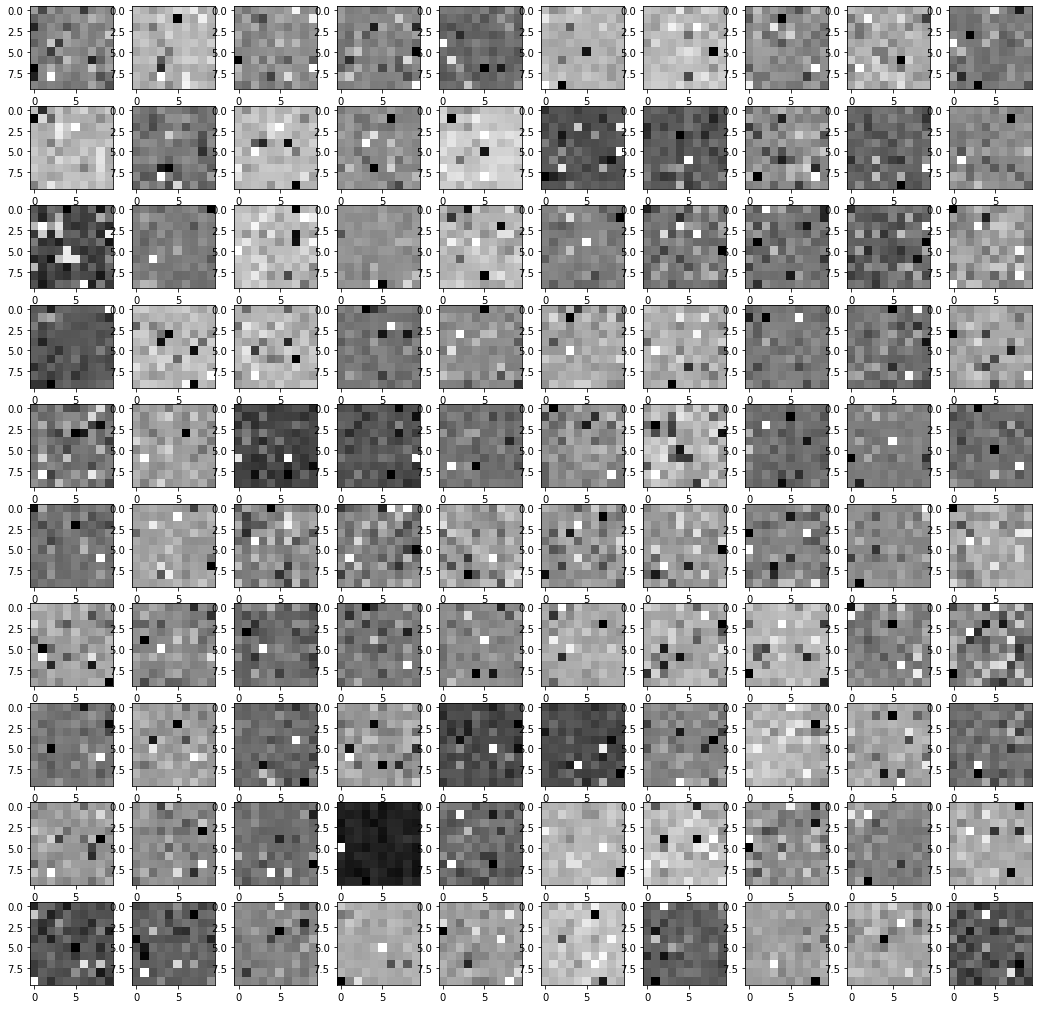

In [23]:
# visualising layer 2
learned_weights = dbn.rbm_layers[1].w.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(18,18))
for i in range(100): 
    sub = fig.add_subplot(10, 10, i+1)
    sub.imshow(learned_weights[i,:].reshape((10,10)), cmap=plt.cm.gray)
plt.show()

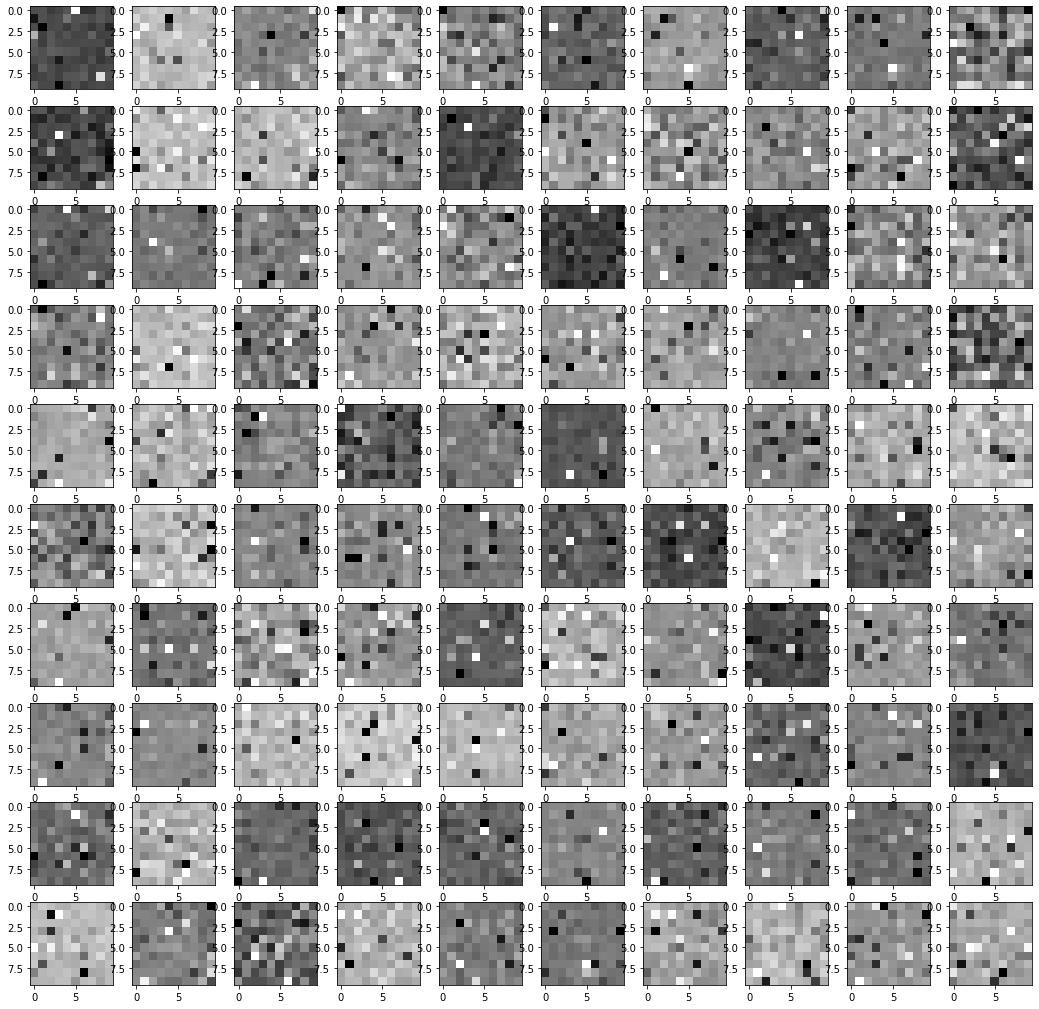

In [24]:
# visualising layer 3
learned_weights = dbn.rbm_layers[2].w.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(18,18))
for i in range(100): 
    sub = fig.add_subplot(10, 10, i+1)
    sub.imshow(learned_weights[i,:].reshape((10,10)), cmap=plt.cm.gray)
plt.show()

## Train a classification model by placing a softmax layer after the DBN

In [25]:
class DBN_Net(torch.nn.Module):
    def __init__(self, dbn, input_dim, output_dim):
        super(DBN_Net, self).__init__()
        self.dbn = dbn
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x, _ = self.dbn.forward(x)
        x = self.linear(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=10):
        history_tr = []
        history_ts = []
        for epoch in range(epochs):
          correct_tr = 0
          total_tr = 0
          y_true_tr = []
          y_pred_tr = []
          loss = 0
          for i, (batch_tr, labels_tr) in enumerate(tr_loader):
            batch_tr = Variable(batch_tr.view(-1, VISIBLE_UNITS))
            labels_tr = Variable(labels_tr)

            optimizer.zero_grad()
            outputs_tr = clf(batch_tr)
            loss_tr = criterion(outputs_tr, labels_tr)
            _, prediction_tr = torch.max(outputs_tr.data, 1)
            y_true_tr.extend(labels_tr)
            y_pred_tr.extend(prediction_tr)
            total_tr += labels_tr.size(0)
            correct_tr += (prediction_tr == labels_tr).sum()
            loss_tr.backward()
            optimizer.step()
            loss += loss_tr / batch_tr.size(0)
          accuracy_tr = correct_tr / total_tr * 100
          history_tr.append(accuracy_tr.data)
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          history_ts.append(accuracy.data)
          print("Epoch : {0:2d} | loss : {1:.4f} | Train Accuracy: {2:.2f}  | Test Accuracy: {3:.2f}".format(epoch+1, loss.item(), accuracy_tr, accuracy))
      
        return y_true_tr, y_pred_tr, y_true, y_pred, history_tr, history_ts

dbn_Model = DBN_Net(dbn, HIDDEN_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(dbn_Model.parameters(), lr=1e-3)
print(dbn_Model)

DBN_Net(
  (dbn): DBN()
  (linear): Linear(in_features=100, out_features=10, bias=True)
)


In [26]:
_,_,_,_,history_train,history_val = dbn_Model.train(train_loader, val_loader, optimizer, dbn_Model, criterion, epochs=40)

Epoch :  1 | loss : 107.6096 | Train Accuracy: 86.35  | Test Accuracy: 90.74
Epoch :  2 | loss : 60.1515 | Train Accuracy: 91.13  | Test Accuracy: 91.81
Epoch :  3 | loss : 54.2913 | Train Accuracy: 91.93  | Test Accuracy: 92.19
Epoch :  4 | loss : 51.4124 | Train Accuracy: 92.31  | Test Accuracy: 92.51
Epoch :  5 | loss : 49.6184 | Train Accuracy: 92.57  | Test Accuracy: 92.74
Epoch :  6 | loss : 48.3669 | Train Accuracy: 92.76  | Test Accuracy: 92.82
Epoch :  7 | loss : 47.4331 | Train Accuracy: 92.87  | Test Accuracy: 92.85
Epoch :  8 | loss : 46.7051 | Train Accuracy: 92.97  | Test Accuracy: 92.91
Epoch :  9 | loss : 46.1195 | Train Accuracy: 93.06  | Test Accuracy: 93.00
Epoch : 10 | loss : 45.6377 | Train Accuracy: 93.13  | Test Accuracy: 93.08
Epoch : 11 | loss : 45.2341 | Train Accuracy: 93.18  | Test Accuracy: 93.12
Epoch : 12 | loss : 44.8913 | Train Accuracy: 93.23  | Test Accuracy: 93.15
Epoch : 13 | loss : 44.5968 | Train Accuracy: 93.27  | Test Accuracy: 93.19
Epoch : 14 

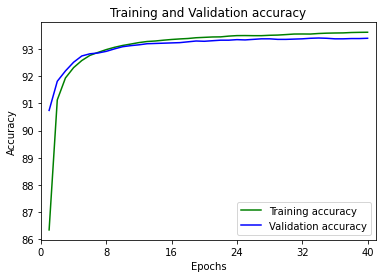

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_train)+1)
plt.plot(epochs, history_train, 'g', label='Training accuracy')
plt.plot(epochs, history_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0, len(history_train)+1])
plt.xticks(np.linspace(0, len(history_train), 6))
plt.legend(loc='lower right')
plt.show()

In [28]:
dbn_Model = DBN_Net(dbn, HIDDEN_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(dbn_Model.parameters(), lr=1e-3)
y_true_tr,y_pred_tr,y_true,y_pred,history_tr,history_ts = dbn_Model.train(tr_loader, ts_loader, optimizer, dbn_Model, criterion, epochs=40)

Epoch :  1 | loss : 121.1107 | Train Accuracy: 87.03  | Test Accuracy: 90.70
Epoch :  2 | loss : 69.9731 | Train Accuracy: 91.34  | Test Accuracy: 92.01
Epoch :  3 | loss : 63.6743 | Train Accuracy: 92.04  | Test Accuracy: 92.44
Epoch :  4 | loss : 60.5554 | Train Accuracy: 92.47  | Test Accuracy: 92.76
Epoch :  5 | loss : 58.6131 | Train Accuracy: 92.66  | Test Accuracy: 92.91
Epoch :  6 | loss : 57.2628 | Train Accuracy: 92.82  | Test Accuracy: 93.03
Epoch :  7 | loss : 56.2606 | Train Accuracy: 92.93  | Test Accuracy: 93.08
Epoch :  8 | loss : 55.4838 | Train Accuracy: 92.99  | Test Accuracy: 93.15
Epoch :  9 | loss : 54.8631 | Train Accuracy: 93.09  | Test Accuracy: 93.22
Epoch : 10 | loss : 54.3560 | Train Accuracy: 93.15  | Test Accuracy: 93.28
Epoch : 11 | loss : 53.9340 | Train Accuracy: 93.20  | Test Accuracy: 93.24
Epoch : 12 | loss : 53.5782 | Train Accuracy: 93.24  | Test Accuracy: 93.32
Epoch : 13 | loss : 53.2746 | Train Accuracy: 93.28  | Test Accuracy: 93.38
Epoch : 14 

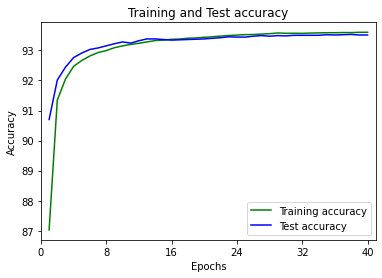

In [29]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_tr)+1)
plt.plot(epochs, history_tr, 'g', label='Training accuracy')
plt.plot(epochs, history_ts, 'b', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0, len(history_tr)+1])
plt.xticks(np.linspace(0, len(history_tr), 6))
plt.legend(loc='lower right')
plt.show()

### Build the confusion matrix :

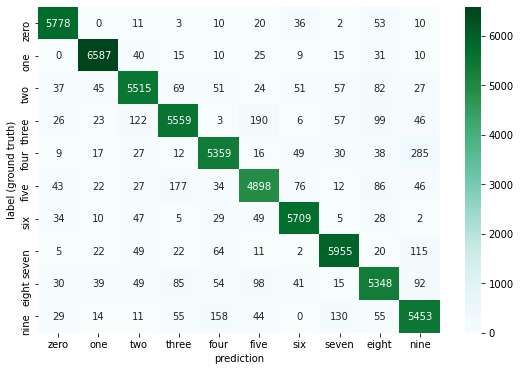

In [30]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Train
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

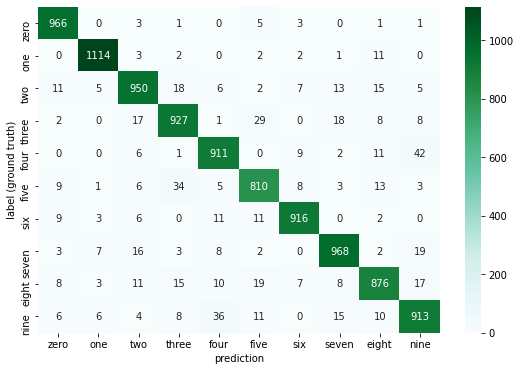

In [31]:
# Test
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

## Train a classification model taking the DBN hidden states as embbedings.

In [32]:
class EMB_DBN_Net(torch.nn.Module):
    def __init__(self, dbn, input_dim, output_dim):
        super(EMB_DBN_Net, self).__init__()
        self.dbn = dbn
        self.fl1 = torch.nn.Linear(input_dim, HIDDEN_UNITS)
        self.fl1.weight.data.copy_(torch.transpose(self.dbn.rbm_layers[0].w, 0, 1))
        self.fl1.bias.data.copy_(self.dbn.rbm_layers[0].hidden_b)
        self.fl2 = torch.nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.fl2.weight.data.copy_(torch.transpose(self.dbn.rbm_layers[1].w, 0, 1))
        self.fl2.bias.data.copy_(self.dbn.rbm_layers[1].hidden_b)
        self.fl3 = torch.nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.fl3.weight.data.copy_(torch.transpose(self.dbn.rbm_layers[2].w, 0, 1))
        self.fl3.bias.data.copy_(self.dbn.rbm_layers[2].hidden_b)
        self.fl4 = torch.nn.Linear(HIDDEN_UNITS, output_dim)

    def forward(self, x):
        x = self.fl1(x)
        x = F.sigmoid(x)
        x = self.fl2(x)
        x = F.sigmoid(x)
        x = self.fl3(x)
        x = F.sigmoid(x)
        x = self.fl4(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=10):
        history_tr = []
        history_ts = []
        for epoch in range(epochs):
          correct_tr = 0
          total_tr = 0
          y_true_tr = []
          y_pred_tr = []
          loss = 0
          for i, (batch_tr, labels_tr) in enumerate(tr_loader):
            batch_tr = Variable(batch_tr.view(-1, VISIBLE_UNITS))
            labels_tr = Variable(labels_tr)

            optimizer.zero_grad()
            outputs_tr = clf(batch_tr)
            loss_tr = criterion(outputs_tr, labels_tr)
            _, prediction_tr = torch.max(outputs_tr.data, 1)
            y_true_tr.extend(labels_tr)
            y_pred_tr.extend(prediction_tr)
            total_tr += labels_tr.size(0)
            correct_tr += (prediction_tr == labels_tr).sum()
            loss_tr.backward()
            optimizer.step()
            loss += loss_tr / batch_tr.size(0)
          accuracy_tr = correct_tr / total_tr * 100
          history_tr.append(accuracy_tr.data)
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          history_ts.append(accuracy.data)
          print("Epoch : {0:2d} | loss : {1:.4f} | Train Accuracy: {2:.2f}  | Test Accuracy: {3:.2f}".format(epoch+1, loss.item(), accuracy_tr, accuracy))
      
        return y_true_tr, y_pred_tr, y_true, y_pred, history_tr, history_ts

emb_dbn_model = EMB_DBN_Net(dbn, VISIBLE_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(emb_dbn_model.parameters(), lr=1e-4)
print(emb_dbn_model)

EMB_DBN_Net(
  (dbn): DBN()
  (fl1): Linear(in_features=784, out_features=100, bias=True)
  (fl2): Linear(in_features=100, out_features=100, bias=True)
  (fl3): Linear(in_features=100, out_features=100, bias=True)
  (fl4): Linear(in_features=100, out_features=10, bias=True)
)


In [33]:
_,_,_,_,history_train,history_val = emb_dbn_model.train(train_loader, val_loader, optimizer, emb_dbn_model, criterion, epochs=100)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :  1 | loss : 243.3191 | Train Accuracy: 72.89  | Test Accuracy: 87.03
Epoch :  2 | loss : 97.2428 | Train Accuracy: 89.27  | Test Accuracy: 90.77
Epoch :  3 | loss : 65.8069 | Train Accuracy: 91.49  | Test Accuracy: 92.29
Epoch :  4 | loss : 53.2996 | Train Accuracy: 92.63  | Test Accuracy: 93.22
Epoch :  5 | loss : 46.1398 | Train Accuracy: 93.44  | Test Accuracy: 93.64
Epoch :  6 | loss : 41.2058 | Train Accuracy: 94.07  | Test Accuracy: 94.12
Epoch :  7 | loss : 37.4545 | Train Accuracy: 94.62  | Test Accuracy: 94.51
Epoch :  8 | loss : 34.4353 | Train Accuracy: 95.06  | Test Accuracy: 94.69
Epoch :  9 | loss : 31.9089 | Train Accuracy: 95.40  | Test Accuracy: 95.02
Epoch : 10 | loss : 29.7447 | Train Accuracy: 95.71  | Test Accuracy: 95.21
Epoch : 11 | loss : 27.8566 | Train Accuracy: 95.96  | Test Accuracy: 95.41
Epoch : 12 | loss : 26.1818 | Train Accuracy: 96.21  | Test Accuracy: 95.72
Epoch : 13 | loss : 24.6753 | Train Accuracy: 96.43  | Test Accuracy: 95.87
Epoch : 14 

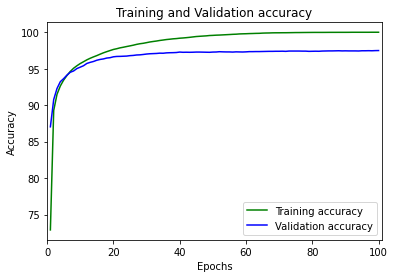

In [34]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_train)+1)
plt.plot(epochs, history_train, 'g', label='Training accuracy')
plt.plot(epochs, history_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0, len(history_train)+1])
plt.xticks(np.linspace(0, len(history_train), 6))
plt.legend(loc='lower right')
plt.show()

In [35]:
emb_dbn_model = EMB_DBN_Net(dbn, VISIBLE_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(emb_dbn_model.parameters(), lr=1e-4)
print(emb_dbn_model)
y_true_tr,y_pred_tr,y_true,y_pred,history_tr,history_ts = emb_dbn_model.train(train_loader, val_loader, optimizer, emb_dbn_model, criterion, epochs=100)

EMB_DBN_Net(
  (dbn): DBN()
  (fl1): Linear(in_features=784, out_features=100, bias=True)
  (fl2): Linear(in_features=100, out_features=100, bias=True)
  (fl3): Linear(in_features=100, out_features=100, bias=True)
  (fl4): Linear(in_features=100, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :  1 | loss : 248.6565 | Train Accuracy: 73.49  | Test Accuracy: 87.33
Epoch :  2 | loss : 98.0621 | Train Accuracy: 89.30  | Test Accuracy: 90.73
Epoch :  3 | loss : 65.6705 | Train Accuracy: 91.47  | Test Accuracy: 92.14
Epoch :  4 | loss : 52.8810 | Train Accuracy: 92.63  | Test Accuracy: 93.11
Epoch :  5 | loss : 45.5633 | Train Accuracy: 93.50  | Test Accuracy: 93.58
Epoch :  6 | loss : 40.5305 | Train Accuracy: 94.16  | Test Accuracy: 94.07
Epoch :  7 | loss : 36.7171 | Train Accuracy: 94.71  | Test Accuracy: 94.59
Epoch :  8 | loss : 33.6598 | Train Accuracy: 95.12  | Test Accuracy: 95.03
Epoch :  9 | loss : 31.1223 | Train Accuracy: 95.51  | Test Accuracy: 95.36
Epoch : 10 | loss : 28.9584 | Train Accuracy: 95.82  | Test Accuracy: 95.58
Epoch : 11 | loss : 27.0774 | Train Accuracy: 96.11  | Test Accuracy: 95.74
Epoch : 12 | loss : 25.4205 | Train Accuracy: 96.38  | Test Accuracy: 95.95
Epoch : 13 | loss : 23.9457 | Train Accuracy: 96.62  | Test Accuracy: 96.10
Epoch : 14 

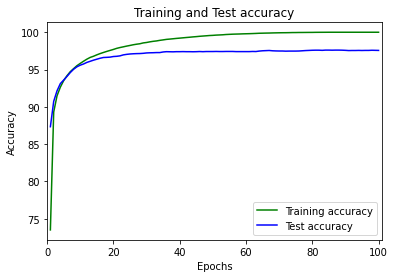

In [36]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_tr)+1)
plt.plot(epochs, history_tr, 'g', label='Training accuracy')
plt.plot(epochs, history_ts, 'b', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0, len(history_tr)+1])
plt.xticks(np.linspace(0, len(history_tr), 6))
plt.legend(loc='lower right')
plt.show()

### Build the confusion matrix :

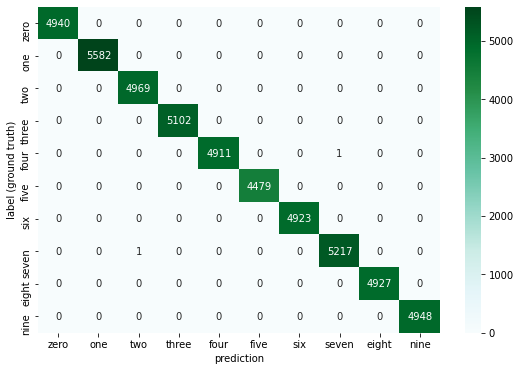

In [37]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Train
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true_tr, y_pred_tr)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

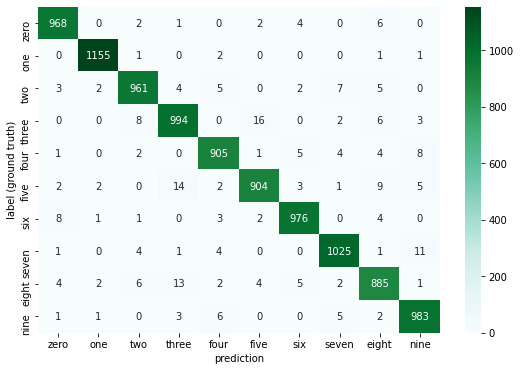

In [38]:
# Test
# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

# **Plot the results**

In [39]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [40]:
examples = enumerate(ts_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [41]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(example_data.view(-1, VISIBLE_UNITS))[0])

In [42]:
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(example_data.view(-1, VISIBLE_UNITS))
recon_data_p_DBN1, recon_data_DBN1 = dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(example_data.view(-1, VISIBLE_UNITS))[0])

### plot raw last batch:

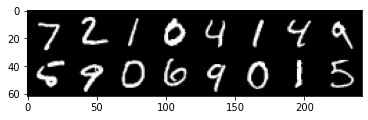

In [43]:
show_adn_save("real",make_grid(example_data.view(example_data.shape[0],1,28,28).data))

### plot reconstructed last batch with propbalitys :

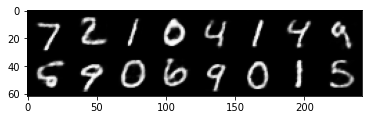

In [44]:
show_adn_save("generate",make_grid(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28).data))

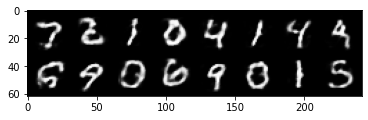

In [45]:
show_adn_save("generate",make_grid(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28).data))

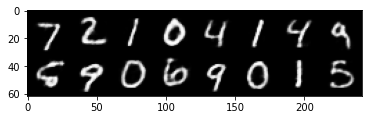

In [46]:
show_adn_save("generate",make_grid(recon_data_p_DBN1.view(recon_data_p_DBN1.shape[0],1,28,28).data))

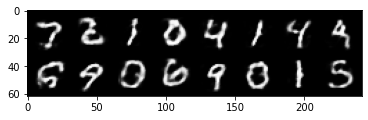

In [47]:
show_adn_save("generate",make_grid(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28).data))

### plot reconstructed last batch with sampled data :

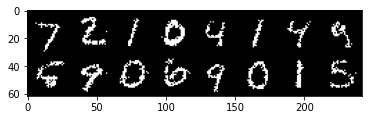

In [48]:
show_adn_save("generate",make_grid(recon_data_RBM.view(recon_data_RBM.shape[0],1,28,28).data))

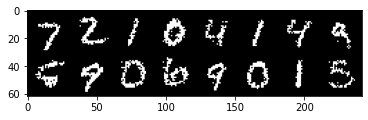

In [49]:
show_adn_save("generate",make_grid(recon_data_DBN1.view(recon_data_DBN1.shape[0],1,28,28).data))

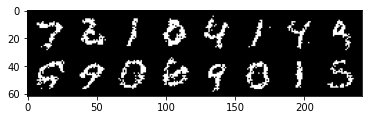

In [50]:
show_adn_save("generate",make_grid(recon_data_DBN.view(recon_data_DBN.shape[0],1,28,28).data))

### plot the reconstruced first batch of test dataset :

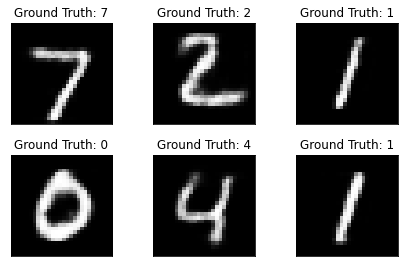

In [51]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28)[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Try to apply affine transformation to the raw img, in result the classifier will make a wrong prediction on the new img: 

In [52]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(example_data[1].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(example_data[1].view(-1, VISIBLE_UNITS))

In [53]:
recon_data_p_DBN1, recon_data_DBN1 = dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(example_data[1].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN2, recon_data_DBN2 = dbn.rbm_layers[0].h2v(dbn.rbm_layers[1].h2v(dbn.rbm_layers[1].v2h(dbn.rbm_layers[0].v2h(example_data[1].view(-1, VISIBLE_UNITS))[0])[0])[1])

Text(0.5, 1.0, 'DBN, Ground Truth: 2')

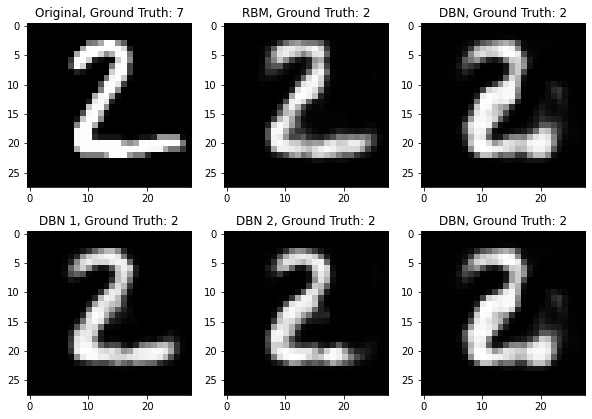

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplot(2,3,1)
plt.imshow(example_data[1][0], cmap='gray', interpolation='none')
plt.title("Original, Ground Truth: {}".format(example_targets[0]))
plt.subplot(2,3,2)
plt.imshow(recon_data_p_RBM.view((28,28)), cmap='gray', interpolation='none')
plt.title("RBM, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,3)
plt.imshow(recon_data_p_DBN.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,4)
plt.imshow(recon_data_p_DBN1.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN 1, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,5)
plt.imshow(recon_data_p_DBN2.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN 2, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,6)
plt.imshow(recon_data_p_DBN.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN, Ground Truth: {}".format(example_targets[1]))

### Define a composed transforms :

In [55]:
compose = transforms.Compose([transforms.RandomAffine(10, translate = (0.02,0.09)),transforms.Resize((28,28))])

### Apply affine transforms :

Text(0.5, 1.0, 'Ground Truth: 2')

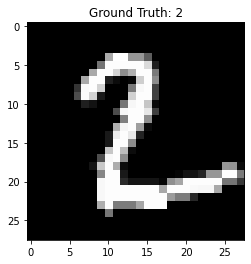

In [56]:
test = example_data[1]
compose(test).shape
plt.imshow(compose(test)[0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[1]))

### Check the prediction :

In [57]:
batch = Variable(compose(test).view(-1, VISIBLE_UNITS))
outputs = emb_dbn_model(batch)
_, prediction = torch.max(outputs.data, 1)
prediction

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([2])

### reconstruct the new img by RBM

In [58]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(compose(test)[0].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(compose(test)[0].view(-1, VISIBLE_UNITS))

### plot the reconstructed new img

Text(0.5, 1.0, 'Ground Truth: 2 but Prediction: 2')

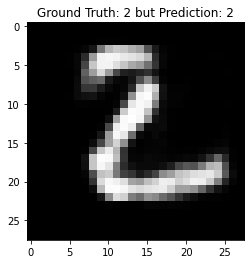

In [59]:
plt.imshow(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28)[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {} but Prediction: {}".format(example_targets[1],*(prediction.numpy())))

Text(0.5, 1.0, 'Ground Truth: 2 but Prediction: 2')

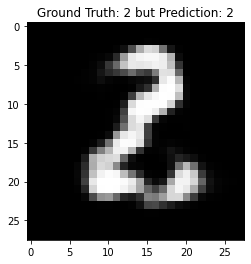

In [60]:
plt.imshow(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28)[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {} but Prediction: {}".format(example_targets[1],*(prediction.numpy())))

# **Gibbs sampling (from random initial status) on Particular mnist**

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


------------------------------------------------------------
Training dbn for number 0
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


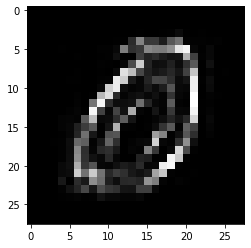

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/0.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 1
------------------------------------------------------------


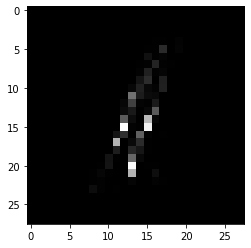

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/1.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 2
------------------------------------------------------------


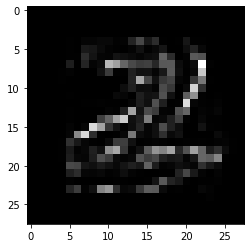

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/2.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 3
------------------------------------------------------------


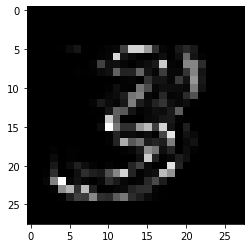

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/3.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 4
------------------------------------------------------------


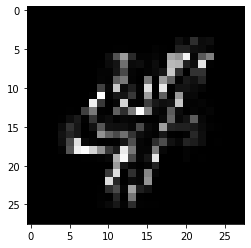

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/4.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 5
------------------------------------------------------------


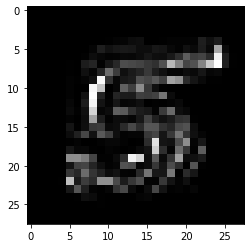

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/5.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 6
------------------------------------------------------------


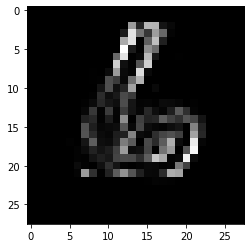

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/6.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 7
------------------------------------------------------------


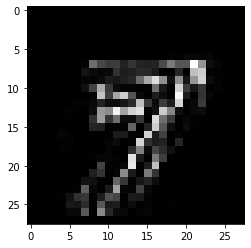

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/7.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 8
------------------------------------------------------------


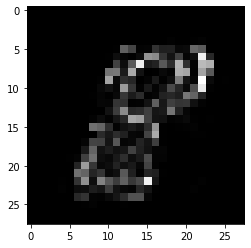

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/8.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 9
------------------------------------------------------------


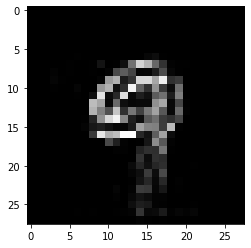

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/9.gif
------------------------------------------------------------


In [62]:
from PIL import Image

N_iters = 100
skip = 1

for number in range(10):
  # A number between 0 and 10.
  print("-"*60)
  print("Training dbn for number {}".format(number))
  print("-"*60)

  particular_mnist = []
  limit = tr_dataset.train_data.shape[0]

  for i in range(limit):
      if(tr_dataset.train_labels[i] == number):
          particular_mnist.append(tr_dataset.train_data[i].numpy())

  len(particular_mnist)
  train_data = torch.stack([torch.Tensor(i) for i in particular_mnist])
  train_label = torch.stack([torch.Tensor(number) for i in range(len(particular_mnist))])
  dbn_p = DBN()
  dbn_p.train(train_data,train_label,debug=False)

  vi = torch.randn(VISIBLE_UNITS)
  for i in range(N_iters):

    vip, vi = dbn_p.reconstruct(vi)
    p = vip.view((28,28))
    img = p.data.numpy()

    if i == N_iters-1:
      plt.imshow(img, cmap='gray')
      plt.show()

    if not i%skip:
      fname = "/content/{}.png".format(i)
      plt.imsave(fname, img, cmap='gray')

  images = []
  for i in range(N_iters):
    if not i%skip:
      fname = "/content/{}.png".format(i)
      img = Image.open(fname)
      images.append(img)
  path = "/content/drive/MyDrive/gifs/dbn/{}.gif".format(number)
  images[0].save(path, save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)
  print("-"*60)
  print("Done, gif image saved in {}".format(path))
  print("-"*60)

------------------------------------------------------------
Training rbm for number 0
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


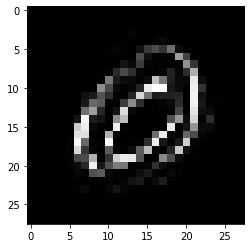

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/rbm/0.gif
------------------------------------------------------------
------------------------------------------------------------
Training rbm for number 1
------------------------------------------------------------


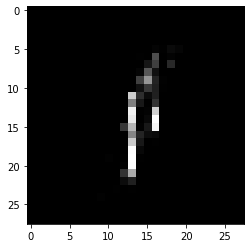

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/rbm/1.gif
------------------------------------------------------------
------------------------------------------------------------
Training rbm for number 2
------------------------------------------------------------


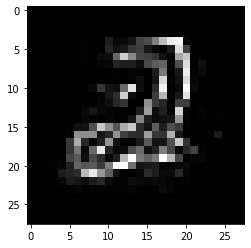

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/rbm/2.gif
------------------------------------------------------------
------------------------------------------------------------
Training rbm for number 3
------------------------------------------------------------


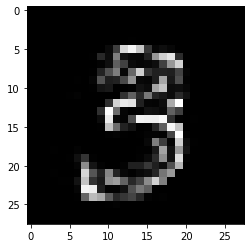

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/rbm/3.gif
------------------------------------------------------------
------------------------------------------------------------
Training rbm for number 4
------------------------------------------------------------


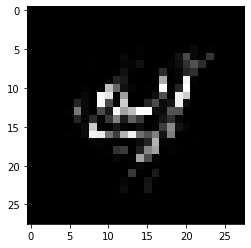

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/rbm/4.gif
------------------------------------------------------------
------------------------------------------------------------
Training rbm for number 5
------------------------------------------------------------


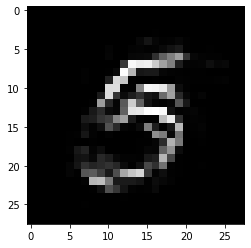

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/rbm/5.gif
------------------------------------------------------------
------------------------------------------------------------
Training rbm for number 6
------------------------------------------------------------


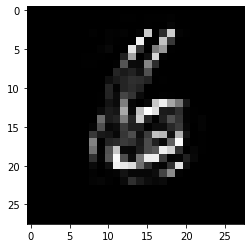

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/rbm/6.gif
------------------------------------------------------------
------------------------------------------------------------
Training rbm for number 7
------------------------------------------------------------


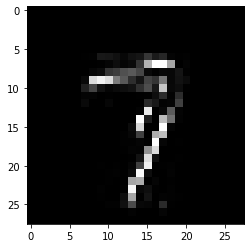

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/rbm/7.gif
------------------------------------------------------------
------------------------------------------------------------
Training rbm for number 8
------------------------------------------------------------


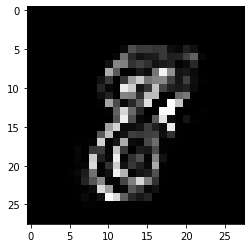

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/rbm/8.gif
------------------------------------------------------------
------------------------------------------------------------
Training rbm for number 9
------------------------------------------------------------


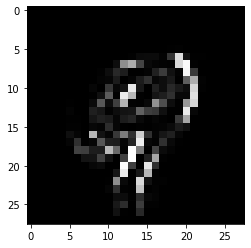

------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/rbm/9.gif
------------------------------------------------------------


In [63]:
from PIL import Image

N_iters = 100
skip = 1

for number in range(10):
  # A number between 0 and 10.
  print("-"*60)
  print("Training rbm for number {}".format(number))
  print("-"*60)

  particular_mnist = []
  limit = tr_dataset.train_data.shape[0]

  for i in range(limit):
      if(tr_dataset.train_labels[i] == number):
          particular_mnist.append(tr_dataset.train_data[i].numpy())

  len(particular_mnist)
  train_data = torch.stack([torch.Tensor(i) for i in particular_mnist])
  train_label = torch.stack([torch.Tensor(number) for i in range(len(particular_mnist))])
  dbn_p = DBN()
  dbn_p.train(train_data,train_label,debug=False)

  vi = torch.randn(VISIBLE_UNITS)
  for i in range(N_iters):
    hip, hi = dbn_p.rbm_layers[0].v2h(vi)
    vip, vi = dbn_p.rbm_layers[0].h2v(hi)
    p = vip.view((28,28))
    img = p.data.numpy()

    if i == N_iters-1:
      plt.imshow(img, cmap='gray')
      plt.show()

    if not i%skip:
      fname = "/content/{}.png".format(i)
      plt.imsave(fname, img, cmap='gray')

  images = []
  for i in range(N_iters):
    if not i%skip:
      fname = "/content/{}.png".format(i)
      img = Image.open(fname)
      images.append(img)
  path = "/content/drive/MyDrive/gifs/rbm/{}.gif".format(number)
  images[0].save(path, save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)
  print("-"*60)
  print("Done, gif image saved in {}".format(path))
  print("-"*60)

# **Reconstruct the uploaded images**:

In [64]:
imgdir = "/content/drive/MyDrive/test_images"
ts_dataset1 = datasets.ImageFolder(imgdir, transform= transforms.Compose(
        [transforms.ToTensor(), transforms.Grayscale(num_output_channels=1), transforms.Resize([28,28])]))
ts_loader1 = torch.utils.data.DataLoader(ts_dataset1, batch_size=1)

examples1 = enumerate(ts_loader1)
batch_idx1, (example_data1, example_targets1) = next(examples1)
img = example_data1[0][0]
img = 1 - img

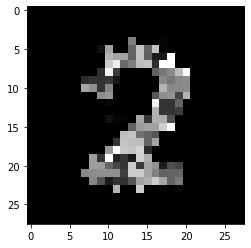

The reconstructed image


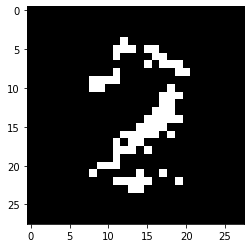

In [65]:
_,reconstructed_img_rbm= dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(img.view(-1, VISIBLE_UNITS))[0])
reconstructed_img_rbm = reconstructed_img_rbm.view((28,28))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img_rbm , cmap = 'gray')
plt.show()

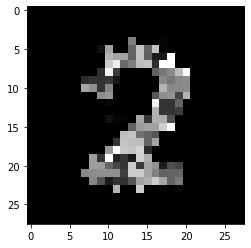

The reconstructed image


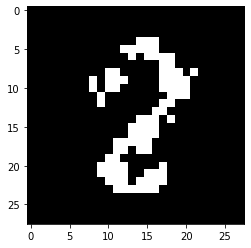

In [66]:
_,reconstructed_img_rbm= dbn.reconstruct(img.view(-1, VISIBLE_UNITS))
reconstructed_img_rbm = reconstructed_img_rbm.view((28,28))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img_rbm , cmap = 'gray')
plt.show()

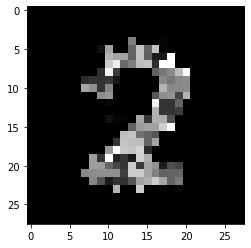

The reconstructed image


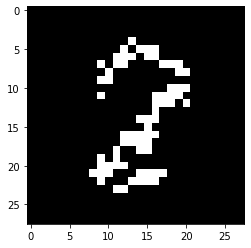

In [67]:
_,reconstructed_img_rbm= rbm.h2v(rbm.v2h(img.view(-1, VISIBLE_UNITS))[0])
reconstructed_img_rbm = reconstructed_img_rbm.view((28,28))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img_rbm , cmap = 'gray')
plt.show()